In [1]:
# prepared dataset
dataset_path = 'data/nature_data.npz'

# saved model name
model_name = 'best_pretrained_ResNet50.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [2]:
import numpy as np

In [3]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [6]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [10]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [11]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Model

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [13]:
# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

94773248/94765736 [==============================] - 2s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 18s 133ms/step - loss: 1.3618 - fbeta: 0.6349 - val_loss: 0.3073 - val_fbeta: 0.8025
Epoch 2/200
64/64 [==============================] - 7s 110ms/step - loss: 0.1054 - fbeta: 0.9263 - val_loss: 0.3399 - val_fbeta: 0.8060
Epoch 3/200
64/64 [==============================] - 7s 110ms/step - loss: 0.0450 - fbeta: 0.9710 - val_loss: 0.3181 - val_fbeta: 0.8384
Epoch 4/200
64/64 [==============================] - 7s 111ms/step - loss: 0.0180 - fbeta: 0.9904 - val_loss: 0.3551 - val_fbeta: 0.8304
Epoch 5/200
64/64 [==============================] - 7s 110ms/step - loss: 0.0115 - fbeta: 0.9943 - val_loss: 0.3605 - val_fbeta: 0.8119
Epoch 6/200
64/64 [==============================] - 7s 111ms/step - loss: 0.0059 - fbeta: 0.9973 - val_loss: 0.4110 - val_fbeta: 0.8167
Epoch 7/200
64/64 [==============================] - 7s 111ms/step - loss: 0.0058 - fbeta: 0.9982 - val_loss: 0.4210 - val_fbeta: 0.8030
Epoch 8/200
64/64 [=====================

In [18]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

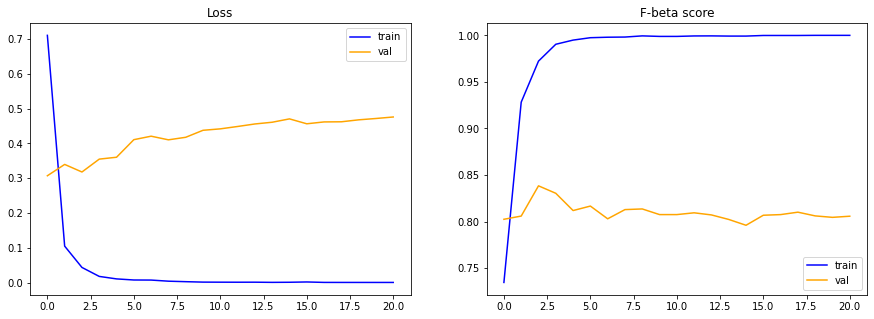

Model F-beta score :  0.8290965557098389


In [17]:
baseline_perf = evaluate_model(history)

Note : overfitting

## Improved Models

### model 1 : set last block as trainable

Epoch 1/200
64/64 [==============================] - 12s 131ms/step - loss: 0.9702 - fbeta: 0.6768 - val_loss: 0.3071 - val_fbeta: 0.8120
Epoch 2/200
64/64 [==============================] - 7s 114ms/step - loss: 0.0787 - fbeta: 0.9496 - val_loss: 0.3289 - val_fbeta: 0.8047
Epoch 3/200
64/64 [==============================] - 7s 114ms/step - loss: 0.0312 - fbeta: 0.9834 - val_loss: 0.2977 - val_fbeta: 0.8298
Epoch 4/200
64/64 [==============================] - 7s 114ms/step - loss: 0.0164 - fbeta: 0.9932 - val_loss: 0.3511 - val_fbeta: 0.8315
Epoch 5/200
64/64 [==============================] - 7s 113ms/step - loss: 0.0075 - fbeta: 0.9978 - val_loss: 0.3885 - val_fbeta: 0.8318
Epoch 6/200
64/64 [==============================] - 7s 113ms/step - loss: 0.0077 - fbeta: 0.9988 - val_loss: 0.3428 - val_fbeta: 0.8197
Epoch 7/200
64/64 [==============================] - 7s 114ms/step - loss: 0.0012 - fbeta: 0.9998 - val_loss: 0.3482 - val_fbeta: 0.8258
Epoch 8/200
64/64 [=====================

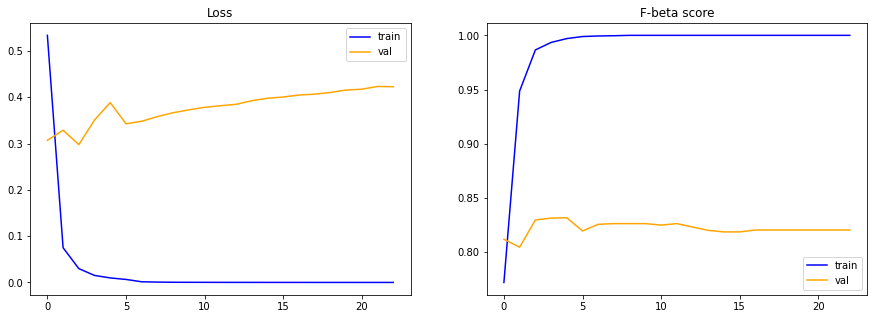

Model F-beta score :  0.8488188982009888


In [19]:
# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last block as trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model1_perf = evaluate_model(history)

Note : overfitting, the performance is little higher than baseline model

### model 2 : Baseline + dropout layer

Epoch 1/200
64/64 [==============================] - 12s 129ms/step - loss: 1.1926 - fbeta: 0.6493 - val_loss: 0.2516 - val_fbeta: 0.8140
Epoch 2/200
64/64 [==============================] - 7s 112ms/step - loss: 0.2233 - fbeta: 0.8800 - val_loss: 0.2931 - val_fbeta: 0.8285
Epoch 3/200
64/64 [==============================] - 7s 111ms/step - loss: 0.1474 - fbeta: 0.9117 - val_loss: 0.2816 - val_fbeta: 0.8040
Epoch 4/200
64/64 [==============================] - 7s 112ms/step - loss: 0.1109 - fbeta: 0.9167 - val_loss: 0.3658 - val_fbeta: 0.7908
Epoch 5/200
64/64 [==============================] - 7s 110ms/step - loss: 0.0921 - fbeta: 0.9430 - val_loss: 0.2900 - val_fbeta: 0.8166
Epoch 6/200
64/64 [==============================] - 7s 111ms/step - loss: 0.0716 - fbeta: 0.9542 - val_loss: 0.3045 - val_fbeta: 0.8028
Epoch 7/200
64/64 [==============================] - 7s 111ms/step - loss: 0.0732 - fbeta: 0.9541 - val_loss: 0.3357 - val_fbeta: 0.8097
Epoch 8/200
64/64 [=====================

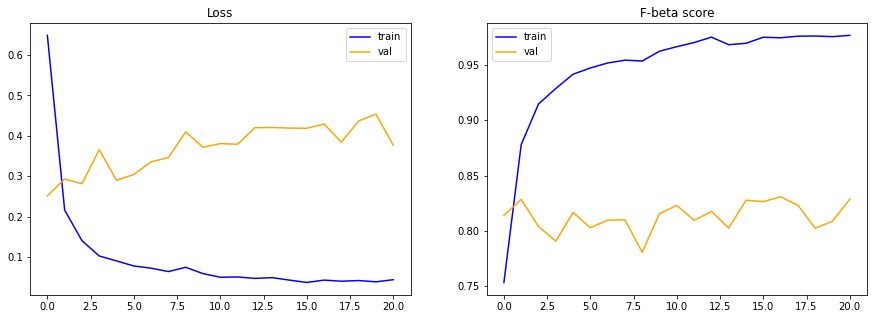

Model F-beta score :  0.853878378868103


In [20]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)

# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model2_perf = evaluate_model(history)

Note : over fitting still occurs, the performance is higher than baseline model

### model 3 : Baseline model + data augmentation

Epoch 1/200
64/64 [==============================] - 13s 153ms/step - loss: 1.7947 - fbeta: 0.5383 - val_loss: 0.3764 - val_fbeta: 0.6722
Epoch 2/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3628 - fbeta: 0.6938 - val_loss: 0.3416 - val_fbeta: 0.7151
Epoch 3/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3210 - fbeta: 0.7427 - val_loss: 0.2999 - val_fbeta: 0.7425
Epoch 4/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2464 - fbeta: 0.7916 - val_loss: 0.3513 - val_fbeta: 0.6981
Epoch 5/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2344 - fbeta: 0.8040 - val_loss: 0.3271 - val_fbeta: 0.7291
Epoch 6/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2090 - fbeta: 0.8240 - val_loss: 0.3425 - val_fbeta: 0.7260
Epoch 7/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2214 - fbeta: 0.8216 - val_loss: 0.2963 - val_fbeta: 0.7636
Epoch 8/200
64/64 [=====================

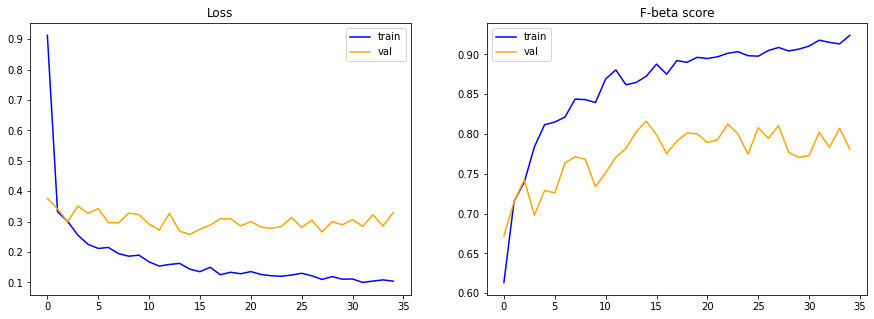

Model F-beta score :  0.8561891317367554


In [21]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model3_perf = evaluate_model(history)

Note : 

### model 4 : Baseline model + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 13s 157ms/step - loss: 1.2887 - fbeta: 0.4284 - val_loss: 0.4057 - val_fbeta: 0.6408
Epoch 2/200
64/64 [==============================] - 9s 134ms/step - loss: 0.4226 - fbeta: 0.6065 - val_loss: 0.3598 - val_fbeta: 0.6803
Epoch 3/200
64/64 [==============================] - 9s 134ms/step - loss: 0.3822 - fbeta: 0.6514 - val_loss: 0.3204 - val_fbeta: 0.6839
Epoch 4/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3431 - fbeta: 0.6510 - val_loss: 0.3129 - val_fbeta: 0.7131
Epoch 5/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3020 - fbeta: 0.7041 - val_loss: 0.3418 - val_fbeta: 0.7018
Epoch 6/200
64/64 [==============================] - 9s 133ms/step - loss: 0.3278 - fbeta: 0.6674 - val_loss: 0.2978 - val_fbeta: 0.7338
Epoch 7/200
64/64 [==============================] - 9s 135ms/step - loss: 0.3058 - fbeta: 0.7110 - val_loss: 0.2972 - val_fbeta: 0.7515
Epoch 8/200
64/64 [=====================

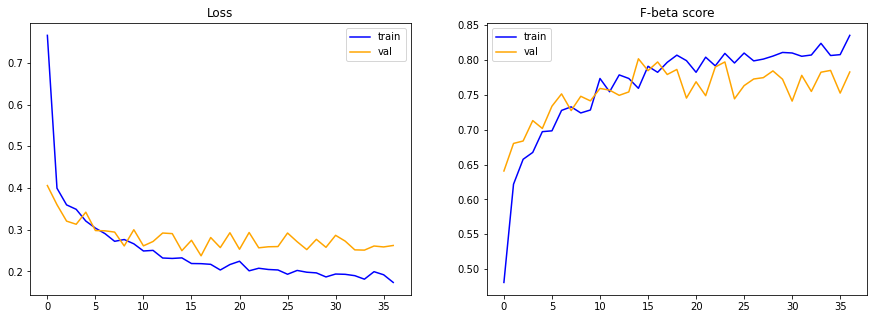

Model F-beta score :  0.8352077603340149


In [22]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model4_perf = evaluate_model(history)

Note : overfitting is reduced

### model 5 : set last block trainable + data augmentation + dropout layer

Epoch 1/200
64/64 [==============================] - 14s 159ms/step - loss: 1.0794 - fbeta: 0.5444 - val_loss: 0.3679 - val_fbeta: 0.6874
Epoch 2/200
64/64 [==============================] - 9s 140ms/step - loss: 0.3279 - fbeta: 0.6903 - val_loss: 0.3161 - val_fbeta: 0.7010
Epoch 3/200
64/64 [==============================] - 9s 140ms/step - loss: 0.2949 - fbeta: 0.7094 - val_loss: 0.3023 - val_fbeta: 0.7319
Epoch 4/200
64/64 [==============================] - 9s 136ms/step - loss: 0.2338 - fbeta: 0.7958 - val_loss: 0.3114 - val_fbeta: 0.7062
Epoch 5/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2449 - fbeta: 0.7970 - val_loss: 0.2707 - val_fbeta: 0.7350
Epoch 6/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2106 - fbeta: 0.8224 - val_loss: 0.3004 - val_fbeta: 0.7403
Epoch 7/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2019 - fbeta: 0.8248 - val_loss: 0.2953 - val_fbeta: 0.7456
Epoch 8/200
64/64 [=====================

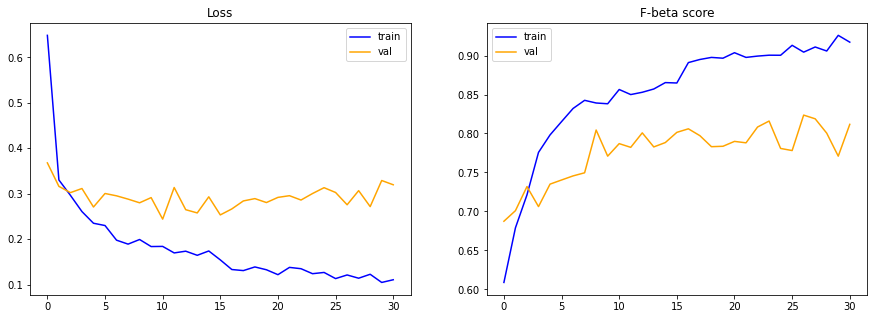

Model F-beta score :  0.8534020185470581


In [23]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last block as trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model5_perf = evaluate_model(history)

Note : overfitting, but the performance (fbeta score) is high

## Model performance

In [24]:
print('Baseline model : ', baseline_perf)
print('model 1 : ', model1_perf)
print('model 2 : ', model2_perf)
print('model 3 : ', model3_perf)
print('model 4 : ', model4_perf)
print('model 5 : ', model5_perf)

Baseline model :  0.8290965557098389
model 1 :  0.8488188982009888
model 2 :  0.853878378868103
model 3 :  0.8561891317367554
model 4 :  0.8352077603340149
model 5 :  0.8534020185470581


Note : only model 4 is not high overfitting

## Finalize model 4
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

In [25]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)

Epoch 1/300
64/64 [==============================] - 13s 154ms/step - loss: 1.6461 - val_loss: 0.3651

Epoch 00001: val_loss improved from inf to 0.36505, saving model to best_pretrained_ResNet50.h5
Epoch 2/300
64/64 [==============================] - 9s 136ms/step - loss: 0.4041 - val_loss: 0.3200

Epoch 00002: val_loss improved from 0.36505 to 0.32003, saving model to best_pretrained_ResNet50.h5
Epoch 3/300
64/64 [==============================] - 9s 135ms/step - loss: 0.3343 - val_loss: 0.2962

Epoch 00003: val_loss improved from 0.32003 to 0.29620, saving model to best_pretrained_ResNet50.h5
Epoch 4/300
64/64 [==============================] - 9s 135ms/step - loss: 0.3527 - val_loss: 0.2969

Epoch 00004: val_loss did not improve from 0.29620
Epoch 5/300
64/64 [==============================] - 9s 135ms/step - loss: 0.2949 - val_loss: 0.3315

Epoch 00005: val_loss did not improve from 0.29620
Epoch 6/300
64/64 [==============================] - 9s 135ms/step - loss: 0.2848 - val_los

## Evaluate model

In [26]:
# print y_test
y_test[:5]

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [27]:
# get y_pred
y_pred = model.predict(test_iter)
y_pred = y_pred.round()
print('y_pred shape : ', y_pred.shape)
print(y_pred[:5])

y_pred shape :  (400, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [28]:
# print model score
final_model_fbeta = fbeta(y_test, y_pred)
print('final_model_fbeta : ', final_model_fbeta.numpy())

final_model_fbeta :  0.84483045


In [29]:
!ls

best_pretrained_ResNet50.h5  drive  sample_data


In [30]:
# copy saved model file to the project directory
#import shutil
#import os

#shutil.copyfile(model_name, os.path.join(project_dir,model_name))

'/content/drive/MyDrive/MyProjects/nature_multilabel_image_classification/best_pretrained_ResNet50.h5'